In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/jupyter_launcher/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

sys.path.append(f'{base_dir}/github_repos')
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc #, decomposition
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised

## Import unlabeled training data

In [6]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [7]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

In [8]:
# masks_SYT = data_labeled['SYTmasks']
# labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

In [9]:
# nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
# non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
# labels_SYT = labels_SYT[non_nan]
# masks_SYT = masks_SYT[non_nan]

In [10]:
# X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [11]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


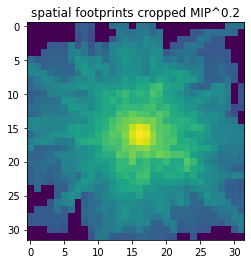

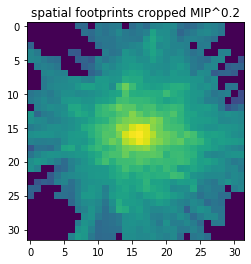

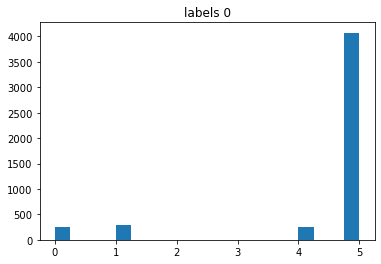

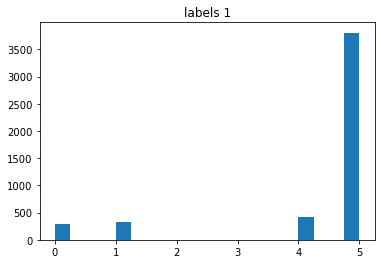

In [12]:
dir_folders = f'{base_dir}/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

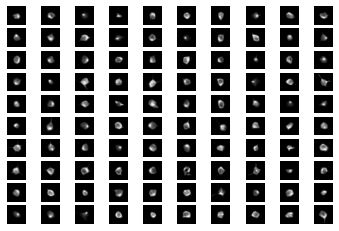

In [13]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [14]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [15]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [16]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

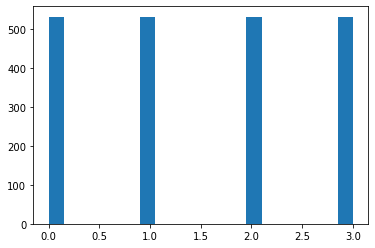

In [17]:
plt.figure()
plt.hist(labels_dup, 20);

In [18]:
images.shape

(2128, 32, 32)

# Train

In [19]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [20]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 512
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [21]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [22]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)
for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [23]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [24]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [25]:
# unfreeze particular blocks in ResNet model

for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 6:
            param.requires_grad = False
        elif int(name[11]) >= 6:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

base_model.6.0.conv1.weight
base_model.6.0.bn1.weight
base_model.6.0.bn1.bias
base_model.6.0.conv2.weight
base_model.6.0.bn2.weight
base_model.6.0.bn2.bias
base_model.6.0.downsample.0.weight
base_model.6.0.downsample.1.weight
base_model.6.0.downsample.1.bias
base_model.6.1.conv1.weight
base_model.6.1.bn1.weight
base_model.6.1.bn1.bias
base_model.6.1.conv2.weight
base_model.6.1.bn2.weight
base_model.6.1.bn2.bias
base_model.7.0.conv1.weight
base_model.7.0.bn1.weight
base_model.7.0.bn1.bias
base_model.7.0.conv2.weight
base_model.7.0.bn2.weight
base_model.7.0.bn2.bias
base_model.7.0.downsample.0.weight
base_model.7.0.downsample.1.weight
base_model.7.0.downsample.1.bias
base_model.7.1.conv1.weight
base_model.7.1.bn1.weight
base_model.7.1.bn1.bias
base_model.7.1.conv2.weight
base_model.7.1.bn2.weight
base_model.7.1.bn2.bias
PreHead_0.weight
PreHead_0.bias
PreHead_1.weight
PreHead_1.bias
PostHead_0.weight
PostHead_0.bias
Classifier_0.weight
Classifier_0.bias


## Define augmentation pipeline

In [26]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
                                        scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
                                        shear=(-15, 15, -15, 15),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(4.5), 10**(6.)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.00015,
                                    prob=1),
    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    
#     torchvision.transforms.Resize(size=(224,224), 
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
    augmentation.TileChannels(dim=0, n_channels=3),
)
scripted_transforms = torch.jit.script(transforms)

In [27]:
dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

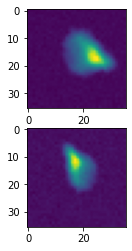

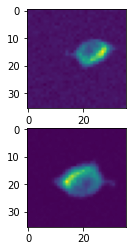

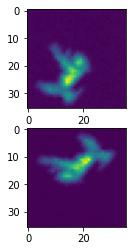

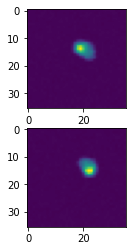

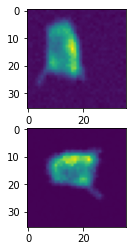

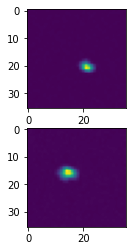

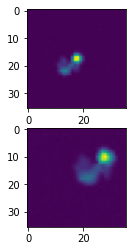

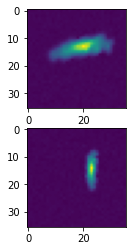

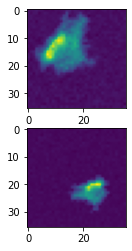

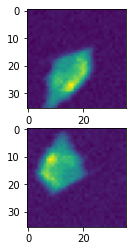

In [28]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(2)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [29]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [30]:
model.to(DEVICE)
model.prep_contrast()

In [31]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=norsz'
model.forward = model.forward_latent


l2_alpha = 0.000

n_epochs=300000
for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

    losses_train_npy = np.array(losses_train)
    losses_val_npy = np.array(losses_val)
    val_accs_npy = np.array(val_accs)
    acc_npy = np.array(acc)

    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

  0%|          | 0/300000 [00:00<?, ?it/s]

epoch: 0
Iter: 0/695, loss_train: 7.591, loss_val: nan, pos_over_neg: 1.02825129032135 lr: 0.00031623
Iter: 1/695, loss_train: 7.3941, loss_val: nan, pos_over_neg: 1.3315545320510864 lr: 0.00031623
Iter: 2/695, loss_train: 7.0508, loss_val: nan, pos_over_neg: 6.396546363830566 lr: 0.00031623
Iter: 3/695, loss_train: 6.9203, loss_val: nan, pos_over_neg: 11.492571830749512 lr: 0.00031623
Iter: 4/695, loss_train: 6.8197, loss_val: nan, pos_over_neg: 8.765219688415527 lr: 0.00031623
Iter: 5/695, loss_train: 6.7804, loss_val: nan, pos_over_neg: 10.172344207763672 lr: 0.00031623
Iter: 6/695, loss_train: 6.6962, loss_val: nan, pos_over_neg: 15.762861251831055 lr: 0.00031623
Iter: 7/695, loss_train: 6.6413, loss_val: nan, pos_over_neg: 29.028417587280273 lr: 0.00031623
Iter: 8/695, loss_train: 6.5968, loss_val: nan, pos_over_neg: 60.8462028503418 lr: 0.00031623
Iter: 9/695, loss_train: 6.5885, loss_val: nan, pos_over_neg: 88.1756362915039 lr: 0.00031623
Iter: 10/695, loss_train: 6.5705, loss_v

  0%|          | 1/300000 [02:54<14554:23:13, 174.65s/it]

epoch: 1
Iter: 0/695, loss_train: 6.0729, loss_val: nan, pos_over_neg: 1023.3244018554688 lr: 0.00031623
Iter: 1/695, loss_train: 6.0854, loss_val: nan, pos_over_neg: 3359.439453125 lr: 0.00031623
Iter: 2/695, loss_train: 6.0853, loss_val: nan, pos_over_neg: 773.6943969726562 lr: 0.00031623
Iter: 3/695, loss_train: 6.0779, loss_val: nan, pos_over_neg: 564.9317016601562 lr: 0.00031623
Iter: 4/695, loss_train: 6.0777, loss_val: nan, pos_over_neg: 2601.806640625 lr: 0.00031623
Iter: 5/695, loss_train: 6.0788, loss_val: nan, pos_over_neg: 886.245361328125 lr: 0.00031623
Iter: 6/695, loss_train: 6.0753, loss_val: nan, pos_over_neg: 596.8372802734375 lr: 0.00031623
Iter: 7/695, loss_train: 6.0859, loss_val: nan, pos_over_neg: 528.7576293945312 lr: 0.00031623
Iter: 8/695, loss_train: 6.0642, loss_val: nan, pos_over_neg: 1108.8026123046875 lr: 0.00031623
Iter: 9/695, loss_train: 6.0764, loss_val: nan, pos_over_neg: 1304.736328125 lr: 0.00031623
Iter: 10/695, loss_train: 6.0807, loss_val: nan, 

  0%|          | 2/300000 [05:45<14348:01:25, 172.18s/it]

epoch: 2
Iter: 0/695, loss_train: 6.0346, loss_val: nan, pos_over_neg: -14783.6865234375 lr: 0.00031623
Iter: 1/695, loss_train: 6.0409, loss_val: nan, pos_over_neg: -2883.859375 lr: 0.00031623
Iter: 2/695, loss_train: 6.0436, loss_val: nan, pos_over_neg: 27373.7265625 lr: 0.00031623
Iter: 3/695, loss_train: 6.047, loss_val: nan, pos_over_neg: 1351.6494140625 lr: 0.00031623
Iter: 4/695, loss_train: 6.0468, loss_val: nan, pos_over_neg: 1782.6761474609375 lr: 0.00031623
Iter: 5/695, loss_train: 6.0429, loss_val: nan, pos_over_neg: 931.324951171875 lr: 0.00031623
Iter: 6/695, loss_train: 6.0413, loss_val: nan, pos_over_neg: 735.891357421875 lr: 0.00031623
Iter: 7/695, loss_train: 6.0385, loss_val: nan, pos_over_neg: 1550.4959716796875 lr: 0.00031623
Iter: 8/695, loss_train: 6.0455, loss_val: nan, pos_over_neg: 1508.395263671875 lr: 0.00031623
Iter: 9/695, loss_train: 6.0521, loss_val: nan, pos_over_neg: 733.1430053710938 lr: 0.00031623
Iter: 10/695, loss_train: 6.0493, loss_val: nan, pos_

  0%|          | 3/300000 [08:35<14288:48:17, 171.47s/it]

epoch: 3
Iter: 0/695, loss_train: 6.0188, loss_val: nan, pos_over_neg: 1113.519287109375 lr: 0.00031623
Iter: 1/695, loss_train: 6.0431, loss_val: nan, pos_over_neg: 1528.4493408203125 lr: 0.00031623
Iter: 2/695, loss_train: 6.0264, loss_val: nan, pos_over_neg: 916.9176025390625 lr: 0.00031623
Iter: 3/695, loss_train: 6.0142, loss_val: nan, pos_over_neg: 806.1954345703125 lr: 0.00031623
Iter: 4/695, loss_train: 6.0088, loss_val: nan, pos_over_neg: 1219.10498046875 lr: 0.00031623
Iter: 5/695, loss_train: 6.0129, loss_val: nan, pos_over_neg: -16135.8525390625 lr: 0.00031623
Iter: 6/695, loss_train: 6.0085, loss_val: nan, pos_over_neg: 1857.203369140625 lr: 0.00031623
Iter: 7/695, loss_train: 6.0155, loss_val: nan, pos_over_neg: 1059.0028076171875 lr: 0.00031623
Iter: 8/695, loss_train: 6.0199, loss_val: nan, pos_over_neg: 2235.651611328125 lr: 0.00031623
Iter: 9/695, loss_train: 6.024, loss_val: nan, pos_over_neg: 1555.8538818359375 lr: 0.00031623
Iter: 10/695, loss_train: 6.013, loss_va

  0%|          | 4/300000 [11:26<14255:30:04, 171.07s/it]

epoch: 4
Iter: 0/695, loss_train: 6.0059, loss_val: nan, pos_over_neg: 880.8731689453125 lr: 0.00031623
Iter: 1/695, loss_train: 6.0078, loss_val: nan, pos_over_neg: 2108.879638671875 lr: 0.00031623
Iter: 2/695, loss_train: 6.0008, loss_val: nan, pos_over_neg: 497.4639587402344 lr: 0.00031623
Iter: 3/695, loss_train: 6.0073, loss_val: nan, pos_over_neg: 2361.55810546875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9973, loss_val: nan, pos_over_neg: 4465.3369140625 lr: 0.00031623
Iter: 5/695, loss_train: 5.993, loss_val: nan, pos_over_neg: -6395.7021484375 lr: 0.00031623
Iter: 6/695, loss_train: 6.0166, loss_val: nan, pos_over_neg: 1881.785400390625 lr: 0.00031623
Iter: 7/695, loss_train: 6.0122, loss_val: nan, pos_over_neg: 852.18701171875 lr: 0.00031623
Iter: 8/695, loss_train: 6.0017, loss_val: nan, pos_over_neg: 2501.896484375 lr: 0.00031623
Iter: 9/695, loss_train: 6.0075, loss_val: nan, pos_over_neg: 1101.49755859375 lr: 0.00031623
Iter: 10/695, loss_train: 6.0077, loss_val: nan, pos

  0%|          | 5/300000 [14:16<14229:42:58, 170.76s/it]

epoch: 5
Iter: 0/695, loss_train: 5.9895, loss_val: nan, pos_over_neg: 1508.549560546875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9994, loss_val: nan, pos_over_neg: 9585.990234375 lr: 0.00031623
Iter: 2/695, loss_train: 5.9972, loss_val: nan, pos_over_neg: 10301.361328125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9865, loss_val: nan, pos_over_neg: 3922.166015625 lr: 0.00031623
Iter: 4/695, loss_train: 6.0132, loss_val: nan, pos_over_neg: 940.5323486328125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9838, loss_val: nan, pos_over_neg: -4094.47119140625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9684, loss_val: nan, pos_over_neg: 63813.41796875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9884, loss_val: nan, pos_over_neg: 2323.18896484375 lr: 0.00031623
Iter: 8/695, loss_train: 5.9818, loss_val: nan, pos_over_neg: 1631.223388671875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9838, loss_val: nan, pos_over_neg: 904.3438110351562 lr: 0.00031623
Iter: 10/695, loss_train: 6.0079, loss_val: nan, pos_

  0%|          | 6/300000 [17:07<14227:18:15, 170.73s/it]

epoch: 6
Iter: 0/695, loss_train: 5.9778, loss_val: nan, pos_over_neg: 830.2161254882812 lr: 0.00031623
Iter: 1/695, loss_train: 5.9753, loss_val: nan, pos_over_neg: 4040.121826171875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9772, loss_val: nan, pos_over_neg: -6480.07373046875 lr: 0.00031623
Iter: 3/695, loss_train: 5.9781, loss_val: nan, pos_over_neg: -3720.685302734375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9837, loss_val: nan, pos_over_neg: 1541.5733642578125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9674, loss_val: nan, pos_over_neg: -6602.587890625 lr: 0.00031623
Iter: 6/695, loss_train: 5.983, loss_val: nan, pos_over_neg: 1898.6500244140625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9857, loss_val: nan, pos_over_neg: 1987.9515380859375 lr: 0.00031623
Iter: 8/695, loss_train: 5.981, loss_val: nan, pos_over_neg: -22961.08984375 lr: 0.00031623
Iter: 9/695, loss_train: 5.981, loss_val: nan, pos_over_neg: 1358.188720703125 lr: 0.00031623
Iter: 10/695, loss_train: 5.9852, loss_val: 

  0%|          | 7/300000 [19:57<14231:27:14, 170.78s/it]

epoch: 7
Iter: 0/695, loss_train: 5.9718, loss_val: nan, pos_over_neg: 1427.4169921875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9828, loss_val: nan, pos_over_neg: -18366.484375 lr: 0.00031623
Iter: 2/695, loss_train: 5.9786, loss_val: nan, pos_over_neg: 1433.83056640625 lr: 0.00031623
Iter: 3/695, loss_train: 5.974, loss_val: nan, pos_over_neg: -6311.03466796875 lr: 0.00031623
Iter: 4/695, loss_train: 5.975, loss_val: nan, pos_over_neg: -9284.5556640625 lr: 0.00031623
Iter: 5/695, loss_train: 5.9773, loss_val: nan, pos_over_neg: 6636.48193359375 lr: 0.00031623
Iter: 6/695, loss_train: 5.969, loss_val: nan, pos_over_neg: 1358.99755859375 lr: 0.00031623
Iter: 7/695, loss_train: 5.9594, loss_val: nan, pos_over_neg: 4273.1552734375 lr: 0.00031623
Iter: 8/695, loss_train: 5.9731, loss_val: nan, pos_over_neg: -3744.871826171875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9827, loss_val: nan, pos_over_neg: 3139.3759765625 lr: 0.00031623
Iter: 10/695, loss_train: 5.9641, loss_val: nan, pos_over

  0%|          | 8/300000 [22:48<14236:13:40, 170.84s/it]

epoch: 8
Iter: 0/695, loss_train: 5.9764, loss_val: nan, pos_over_neg: 1629.076416015625 lr: 0.00031623
Iter: 1/695, loss_train: 5.9704, loss_val: nan, pos_over_neg: 1234.4432373046875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9586, loss_val: nan, pos_over_neg: 8342.4912109375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9674, loss_val: nan, pos_over_neg: -11508.4580078125 lr: 0.00031623
Iter: 4/695, loss_train: 5.9636, loss_val: nan, pos_over_neg: -5463.6044921875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9719, loss_val: nan, pos_over_neg: -42390.3046875 lr: 0.00031623
Iter: 6/695, loss_train: 5.9719, loss_val: nan, pos_over_neg: 5831.29296875 lr: 0.00031623
Iter: 7/695, loss_train: 5.966, loss_val: nan, pos_over_neg: 206826.515625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9815, loss_val: nan, pos_over_neg: 2313.5390625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9659, loss_val: nan, pos_over_neg: -2436.28271484375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9678, loss_val: nan, pos_over_ne

  0%|          | 9/300000 [25:39<14233:28:52, 170.81s/it]

epoch: 9
Iter: 0/695, loss_train: 5.9641, loss_val: nan, pos_over_neg: 9236.9130859375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9637, loss_val: nan, pos_over_neg: -7026.60009765625 lr: 0.00031623
Iter: 2/695, loss_train: 5.96, loss_val: nan, pos_over_neg: -7765.57177734375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9678, loss_val: nan, pos_over_neg: 4792.28076171875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9511, loss_val: nan, pos_over_neg: -47547.76953125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9628, loss_val: nan, pos_over_neg: 18751.0078125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9628, loss_val: nan, pos_over_neg: 10082.1884765625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9601, loss_val: nan, pos_over_neg: 2526.464111328125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9656, loss_val: nan, pos_over_neg: 828.9283447265625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9635, loss_val: nan, pos_over_neg: 3055.9580078125 lr: 0.00031623
Iter: 10/695, loss_train: 5.9502, loss_val: nan, pos_ov

  0%|          | 10/300000 [28:30<14224:58:34, 170.71s/it]

epoch: 10
Iter: 0/695, loss_train: 5.9593, loss_val: nan, pos_over_neg: 2657.265380859375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9747, loss_val: nan, pos_over_neg: -7211.69775390625 lr: 0.00031623
Iter: 2/695, loss_train: 5.9605, loss_val: nan, pos_over_neg: -16954.771484375 lr: 0.00031623
Iter: 3/695, loss_train: 5.956, loss_val: nan, pos_over_neg: -2509.23583984375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9648, loss_val: nan, pos_over_neg: 2264.124267578125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9694, loss_val: nan, pos_over_neg: 6653.3056640625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9686, loss_val: nan, pos_over_neg: 1093.3443603515625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9681, loss_val: nan, pos_over_neg: 2736.5966796875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9704, loss_val: nan, pos_over_neg: 49711.5078125 lr: 0.00031623
Iter: 9/695, loss_train: 5.9534, loss_val: nan, pos_over_neg: 1095.78759765625 lr: 0.00031623
Iter: 10/695, loss_train: 5.9708, loss_val: nan, p

  0%|          | 11/300000 [31:21<14235:23:03, 170.83s/it]

epoch: 11
Iter: 0/695, loss_train: 5.9462, loss_val: nan, pos_over_neg: 8792.0283203125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9665, loss_val: nan, pos_over_neg: 16313.591796875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9581, loss_val: nan, pos_over_neg: -35902.53125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9521, loss_val: nan, pos_over_neg: -4969.01806640625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9635, loss_val: nan, pos_over_neg: 6746.61083984375 lr: 0.00031623
Iter: 5/695, loss_train: 5.956, loss_val: nan, pos_over_neg: 1017.7676391601562 lr: 0.00031623
Iter: 6/695, loss_train: 5.9573, loss_val: nan, pos_over_neg: 1273.219482421875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9549, loss_val: nan, pos_over_neg: 3577.015869140625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9583, loss_val: nan, pos_over_neg: 3051.988037109375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9671, loss_val: nan, pos_over_neg: 1020.3971557617188 lr: 0.00031623
Iter: 10/695, loss_train: 5.9611, loss_val: nan, 

  0%|          | 12/300000 [34:12<14252:46:17, 171.04s/it]

epoch: 12
Iter: 0/695, loss_train: 5.9417, loss_val: nan, pos_over_neg: 3733.2373046875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9485, loss_val: nan, pos_over_neg: 4586.18994140625 lr: 0.00031623
Iter: 2/695, loss_train: 5.9524, loss_val: nan, pos_over_neg: -3906.82763671875 lr: 0.00031623
Iter: 3/695, loss_train: 5.9508, loss_val: nan, pos_over_neg: -3453.43603515625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9506, loss_val: nan, pos_over_neg: 7723.498046875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9494, loss_val: nan, pos_over_neg: 1512.103759765625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9545, loss_val: nan, pos_over_neg: 1831.6900634765625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9413, loss_val: nan, pos_over_neg: -2741.88720703125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9307, loss_val: nan, pos_over_neg: -46025.28515625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9433, loss_val: nan, pos_over_neg: 4253.2626953125 lr: 0.00031623
Iter: 10/695, loss_train: 5.9434, loss_val: nan, 

  0%|          | 13/300000 [37:04<14260:39:17, 171.14s/it]

epoch: 13
Iter: 0/695, loss_train: 5.9359, loss_val: nan, pos_over_neg: -2225.489501953125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9566, loss_val: nan, pos_over_neg: 2599.6591796875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9568, loss_val: nan, pos_over_neg: 3281.207275390625 lr: 0.00031623
Iter: 3/695, loss_train: 5.9514, loss_val: nan, pos_over_neg: 2648.256591796875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9526, loss_val: nan, pos_over_neg: -36796.3046875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9523, loss_val: nan, pos_over_neg: 4533.43798828125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9418, loss_val: nan, pos_over_neg: 2560.66162109375 lr: 0.00031623
Iter: 7/695, loss_train: 5.9322, loss_val: nan, pos_over_neg: -41839.4921875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9387, loss_val: nan, pos_over_neg: -6720.822265625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9483, loss_val: nan, pos_over_neg: 1425.372802734375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9439, loss_val: nan, po

  0%|          | 14/300000 [39:55<14272:09:33, 171.27s/it]

epoch: 14
Iter: 0/695, loss_train: 5.9454, loss_val: nan, pos_over_neg: 1187.6160888671875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9431, loss_val: nan, pos_over_neg: 3098.191650390625 lr: 0.00031623
Iter: 2/695, loss_train: 5.9428, loss_val: nan, pos_over_neg: 15115.1474609375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9435, loss_val: nan, pos_over_neg: 2500.651611328125 lr: 0.00031623
Iter: 4/695, loss_train: 5.9395, loss_val: nan, pos_over_neg: -10340.0966796875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9356, loss_val: nan, pos_over_neg: -31130.14453125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9338, loss_val: nan, pos_over_neg: -35485.26171875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9384, loss_val: nan, pos_over_neg: -3232.5654296875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9369, loss_val: nan, pos_over_neg: -1970.488037109375 lr: 0.00031623
Iter: 9/695, loss_train: 5.938, loss_val: nan, pos_over_neg: -4268.28271484375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9328, loss_val: n

  0%|          | 15/300000 [42:47<14284:41:45, 171.42s/it]

epoch: 15
Iter: 0/695, loss_train: 5.9309, loss_val: nan, pos_over_neg: -5354.5908203125 lr: 0.00031623
Iter: 1/695, loss_train: 5.93, loss_val: nan, pos_over_neg: -1721.93359375 lr: 0.00031623
Iter: 2/695, loss_train: 5.9425, loss_val: nan, pos_over_neg: 5237.8720703125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9362, loss_val: nan, pos_over_neg: 2337.181396484375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9448, loss_val: nan, pos_over_neg: 7787.22705078125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9402, loss_val: nan, pos_over_neg: 4130.30224609375 lr: 0.00031623
Iter: 6/695, loss_train: 5.9419, loss_val: nan, pos_over_neg: 2446.37744140625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9389, loss_val: nan, pos_over_neg: -5822.65478515625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9349, loss_val: nan, pos_over_neg: 5921.9287109375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9317, loss_val: nan, pos_over_neg: -4657.673828125 lr: 0.00031623
Iter: 10/695, loss_train: 5.943, loss_val: nan, pos_ove

  0%|          | 16/300000 [45:38<14285:08:51, 171.43s/it]

epoch: 16
Iter: 0/695, loss_train: 5.9487, loss_val: nan, pos_over_neg: 2606.779296875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9332, loss_val: nan, pos_over_neg: 2552.412353515625 lr: 0.00031623
Iter: 2/695, loss_train: 5.9252, loss_val: nan, pos_over_neg: 4626.9873046875 lr: 0.00031623
Iter: 3/695, loss_train: 5.9354, loss_val: nan, pos_over_neg: -2374.026123046875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9495, loss_val: nan, pos_over_neg: -17254.66796875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9302, loss_val: nan, pos_over_neg: -2515.74853515625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9388, loss_val: nan, pos_over_neg: -16819.41796875 lr: 0.00031623
Iter: 7/695, loss_train: 5.938, loss_val: nan, pos_over_neg: -5205.2109375 lr: 0.00031623
Iter: 8/695, loss_train: 5.9345, loss_val: nan, pos_over_neg: 2113.5166015625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9436, loss_val: nan, pos_over_neg: 3861.99267578125 lr: 0.00031623
Iter: 10/695, loss_train: 5.9314, loss_val: nan, pos_ove

  0%|          | 17/300000 [48:29<14269:02:45, 171.24s/it]

epoch: 17
Iter: 0/695, loss_train: 5.9385, loss_val: nan, pos_over_neg: 60058.65234375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9198, loss_val: nan, pos_over_neg: 6271.17529296875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9341, loss_val: nan, pos_over_neg: -6461.056640625 lr: 0.00031623
Iter: 3/695, loss_train: 5.9352, loss_val: nan, pos_over_neg: 1049.153076171875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9355, loss_val: nan, pos_over_neg: 133746.234375 lr: 0.00031623
Iter: 5/695, loss_train: 5.931, loss_val: nan, pos_over_neg: 7977.35546875 lr: 0.00031623
Iter: 6/695, loss_train: 5.9349, loss_val: nan, pos_over_neg: 3933.267333984375 lr: 0.00031623
Iter: 7/695, loss_train: 5.933, loss_val: nan, pos_over_neg: -6576.39453125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9285, loss_val: nan, pos_over_neg: -6568.70849609375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9302, loss_val: nan, pos_over_neg: -3315.740966796875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9291, loss_val: nan, pos_over_

  0%|          | 18/300000 [51:20<14268:45:03, 171.24s/it]

epoch: 18
Iter: 0/695, loss_train: 5.9316, loss_val: nan, pos_over_neg: -4786.32470703125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9354, loss_val: nan, pos_over_neg: 3283.077392578125 lr: 0.00031623
Iter: 2/695, loss_train: 5.9163, loss_val: nan, pos_over_neg: -2171.421142578125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9278, loss_val: nan, pos_over_neg: 19268.166015625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9371, loss_val: nan, pos_over_neg: -5265.96044921875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9249, loss_val: nan, pos_over_neg: -10976.9033203125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9296, loss_val: nan, pos_over_neg: 3762.31103515625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9324, loss_val: nan, pos_over_neg: 1208.1943359375 lr: 0.00031623
Iter: 8/695, loss_train: 5.9449, loss_val: nan, pos_over_neg: 1833.1702880859375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9243, loss_val: nan, pos_over_neg: 15484.8486328125 lr: 0.00031623
Iter: 10/695, loss_train: 5.9306, loss_val: 

  0%|          | 19/300000 [54:12<14270:49:15, 171.26s/it]

epoch: 19
Iter: 0/695, loss_train: 5.9199, loss_val: nan, pos_over_neg: -14153.52734375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9301, loss_val: nan, pos_over_neg: 6410.96240234375 lr: 0.00031623
Iter: 2/695, loss_train: 5.9269, loss_val: nan, pos_over_neg: 2457.861083984375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9256, loss_val: nan, pos_over_neg: 13717.2080078125 lr: 0.00031623
Iter: 4/695, loss_train: 5.9306, loss_val: nan, pos_over_neg: -9993.2802734375 lr: 0.00031623
Iter: 5/695, loss_train: 5.9203, loss_val: nan, pos_over_neg: -7761.95849609375 lr: 0.00031623
Iter: 6/695, loss_train: 5.9241, loss_val: nan, pos_over_neg: -6551.53076171875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9418, loss_val: nan, pos_over_neg: 1307.4302978515625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9278, loss_val: nan, pos_over_neg: 6644.31982421875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9166, loss_val: nan, pos_over_neg: 39758.6796875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9326, loss_val: nan, 

  0%|          | 20/300000 [57:03<14258:33:08, 171.11s/it]

epoch: 20
Iter: 0/695, loss_train: 5.923, loss_val: nan, pos_over_neg: -5392.66455078125 lr: 0.00031623
Iter: 1/695, loss_train: 5.932, loss_val: nan, pos_over_neg: -32708.865234375 lr: 0.00031623
Iter: 2/695, loss_train: 5.9246, loss_val: nan, pos_over_neg: -17052.681640625 lr: 0.00031623
Iter: 3/695, loss_train: 5.9191, loss_val: nan, pos_over_neg: -3092.2119140625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9349, loss_val: nan, pos_over_neg: -5548.41064453125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9214, loss_val: nan, pos_over_neg: -2736.74072265625 lr: 0.00031623
Iter: 6/695, loss_train: 5.928, loss_val: nan, pos_over_neg: 3360.350341796875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9221, loss_val: nan, pos_over_neg: -4578.28271484375 lr: 0.00031623
Iter: 8/695, loss_train: 5.924, loss_val: nan, pos_over_neg: -4612.11181640625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9202, loss_val: nan, pos_over_neg: -5305.1123046875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9162, loss_val: nan,

  0%|          | 21/300000 [59:53<14246:50:15, 170.97s/it]

epoch: 21
Iter: 0/695, loss_train: 5.9262, loss_val: nan, pos_over_neg: -152146.90625 lr: 0.00031623
Iter: 1/695, loss_train: 5.9209, loss_val: nan, pos_over_neg: -18154.39453125 lr: 0.00031623
Iter: 2/695, loss_train: 5.9364, loss_val: nan, pos_over_neg: -3422.616943359375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9329, loss_val: nan, pos_over_neg: -3033.208251953125 lr: 0.00031623
Iter: 4/695, loss_train: 5.9107, loss_val: nan, pos_over_neg: -20441.1953125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9249, loss_val: nan, pos_over_neg: 3262.29541015625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9295, loss_val: nan, pos_over_neg: 18240.427734375 lr: 0.00031623
Iter: 7/695, loss_train: 5.9231, loss_val: nan, pos_over_neg: 8850.2978515625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9221, loss_val: nan, pos_over_neg: -3346.21630859375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9327, loss_val: nan, pos_over_neg: -22818.669921875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9151, loss_val: nan, pos_

  0%|          | 22/300000 [1:02:44<14246:51:10, 170.97s/it]

epoch: 22
Iter: 0/695, loss_train: 5.9284, loss_val: nan, pos_over_neg: -3979.322509765625 lr: 0.00031623
Iter: 1/695, loss_train: 5.9183, loss_val: nan, pos_over_neg: 4613.7548828125 lr: 0.00031623
Iter: 2/695, loss_train: 5.9185, loss_val: nan, pos_over_neg: -102999.3515625 lr: 0.00031623
Iter: 3/695, loss_train: 5.9164, loss_val: nan, pos_over_neg: -4528.6845703125 lr: 0.00031623
Iter: 4/695, loss_train: 5.9084, loss_val: nan, pos_over_neg: -2576.09033203125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9224, loss_val: nan, pos_over_neg: -5332.37255859375 lr: 0.00031623
Iter: 6/695, loss_train: 5.9184, loss_val: nan, pos_over_neg: -5066.00439453125 lr: 0.00031623
Iter: 7/695, loss_train: 5.9114, loss_val: nan, pos_over_neg: -12744.19921875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9191, loss_val: nan, pos_over_neg: -10701.2451171875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9188, loss_val: nan, pos_over_neg: 4894.84765625 lr: 0.00031623
Iter: 10/695, loss_train: 5.9237, loss_val: nan, p

  0%|          | 23/300000 [1:05:35<14245:50:02, 170.96s/it]

epoch: 23
Iter: 0/695, loss_train: 5.9357, loss_val: nan, pos_over_neg: 77214.4375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9214, loss_val: nan, pos_over_neg: -15436.841796875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9236, loss_val: nan, pos_over_neg: -22295.943359375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9092, loss_val: nan, pos_over_neg: 4287.78662109375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9105, loss_val: nan, pos_over_neg: -3246.54638671875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9211, loss_val: nan, pos_over_neg: 10502.73046875 lr: 0.00031623
Iter: 6/695, loss_train: 5.9119, loss_val: nan, pos_over_neg: 2521.234375 lr: 0.00031623
Iter: 7/695, loss_train: 5.909, loss_val: nan, pos_over_neg: -43202.66015625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9262, loss_val: nan, pos_over_neg: 9207.8232421875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9227, loss_val: nan, pos_over_neg: 2053.4248046875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9173, loss_val: nan, pos_over_neg: 144

  0%|          | 24/300000 [1:08:26<14254:49:06, 171.07s/it]

epoch: 24
Iter: 0/695, loss_train: 5.9232, loss_val: nan, pos_over_neg: -3048.485107421875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9204, loss_val: nan, pos_over_neg: -3007.789794921875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9149, loss_val: nan, pos_over_neg: -152963.375 lr: 0.00031623
Iter: 3/695, loss_train: 5.909, loss_val: nan, pos_over_neg: -4293.80517578125 lr: 0.00031623
Iter: 4/695, loss_train: 5.9159, loss_val: nan, pos_over_neg: -61266.69921875 lr: 0.00031623
Iter: 5/695, loss_train: 5.9104, loss_val: nan, pos_over_neg: -1755.148681640625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9266, loss_val: nan, pos_over_neg: 17679.912109375 lr: 0.00031623
Iter: 7/695, loss_train: 5.9048, loss_val: nan, pos_over_neg: 5257.34765625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9186, loss_val: nan, pos_over_neg: 6713.283203125 lr: 0.00031623
Iter: 9/695, loss_train: 5.92, loss_val: nan, pos_over_neg: 3582.1240234375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9173, loss_val: nan, pos_over_n

  0%|          | 25/300000 [1:11:17<14251:31:35, 171.03s/it]

epoch: 25
Iter: 0/695, loss_train: 5.9153, loss_val: nan, pos_over_neg: 4168.552734375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9168, loss_val: nan, pos_over_neg: -14247.8896484375 lr: 0.00031623
Iter: 2/695, loss_train: 5.9139, loss_val: nan, pos_over_neg: 20409.08203125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9164, loss_val: nan, pos_over_neg: -2251.847412109375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9291, loss_val: nan, pos_over_neg: -23506.029296875 lr: 0.00031623
Iter: 5/695, loss_train: 5.92, loss_val: nan, pos_over_neg: -2091.3857421875 lr: 0.00031623
Iter: 6/695, loss_train: 5.9142, loss_val: nan, pos_over_neg: -4645.6162109375 lr: 0.00031623
Iter: 7/695, loss_train: 5.9123, loss_val: nan, pos_over_neg: 10159.5419921875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9136, loss_val: nan, pos_over_neg: 5536.03271484375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9202, loss_val: nan, pos_over_neg: 2269.827880859375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9195, loss_val: nan, pos

  0%|          | 26/300000 [1:14:08<14246:04:05, 170.97s/it]

epoch: 26
Iter: 0/695, loss_train: 5.8959, loss_val: nan, pos_over_neg: -1802.2021484375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9189, loss_val: nan, pos_over_neg: 1831.213134765625 lr: 0.00031623
Iter: 2/695, loss_train: 5.9232, loss_val: nan, pos_over_neg: 1137.7969970703125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9215, loss_val: nan, pos_over_neg: 2287.6181640625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9219, loss_val: nan, pos_over_neg: 2209.111328125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9178, loss_val: nan, pos_over_neg: -2776.876953125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9091, loss_val: nan, pos_over_neg: -2319.50634765625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9131, loss_val: nan, pos_over_neg: -2469.822998046875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9206, loss_val: nan, pos_over_neg: -2189.482421875 lr: 0.00031623
Iter: 9/695, loss_train: 5.917, loss_val: nan, pos_over_neg: 2487.799072265625 lr: 0.00031623
Iter: 10/695, loss_train: 5.919, loss_val: nan, p

  0%|          | 27/300000 [1:16:59<14250:10:00, 171.02s/it]

epoch: 27
Iter: 0/695, loss_train: 5.923, loss_val: nan, pos_over_neg: 1126.009033203125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9052, loss_val: nan, pos_over_neg: 4426.9697265625 lr: 0.00031623
Iter: 2/695, loss_train: 5.8997, loss_val: nan, pos_over_neg: 286604.5625 lr: 0.00031623
Iter: 3/695, loss_train: 5.9207, loss_val: nan, pos_over_neg: -1892.35009765625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9111, loss_val: nan, pos_over_neg: -2169.08642578125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9079, loss_val: nan, pos_over_neg: -5832.97119140625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9164, loss_val: nan, pos_over_neg: -4700.3798828125 lr: 0.00031623
Iter: 7/695, loss_train: 5.9139, loss_val: nan, pos_over_neg: 14231.681640625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9146, loss_val: nan, pos_over_neg: 3320.79248046875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9071, loss_val: nan, pos_over_neg: -2914.6962890625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8979, loss_val: nan, pos_o

  0%|          | 28/300000 [1:19:50<14244:08:25, 170.95s/it]

epoch: 28
Iter: 0/695, loss_train: 5.9067, loss_val: nan, pos_over_neg: -2313.677001953125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9166, loss_val: nan, pos_over_neg: -6871.5546875 lr: 0.00031623
Iter: 2/695, loss_train: 5.915, loss_val: nan, pos_over_neg: -7365.63818359375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9089, loss_val: nan, pos_over_neg: -6127.3515625 lr: 0.00031623
Iter: 4/695, loss_train: 5.9062, loss_val: nan, pos_over_neg: -6247.73095703125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9044, loss_val: nan, pos_over_neg: -2817.65673828125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9097, loss_val: nan, pos_over_neg: -10644.1533203125 lr: 0.00031623
Iter: 7/695, loss_train: 5.9144, loss_val: nan, pos_over_neg: -3370.50732421875 lr: 0.00031623
Iter: 8/695, loss_train: 5.905, loss_val: nan, pos_over_neg: -3038.267578125 lr: 0.00031623
Iter: 9/695, loss_train: 5.9089, loss_val: nan, pos_over_neg: -5475.4228515625 lr: 0.00031623
Iter: 10/695, loss_train: 5.9092, loss_val: nan, pos

  0%|          | 29/300000 [1:22:41<14241:08:47, 170.91s/it]

epoch: 29
Iter: 0/695, loss_train: 5.9155, loss_val: nan, pos_over_neg: 4391.91796875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9021, loss_val: nan, pos_over_neg: -3576.16748046875 lr: 0.00031623
Iter: 2/695, loss_train: 5.904, loss_val: nan, pos_over_neg: -3958.66552734375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9033, loss_val: nan, pos_over_neg: -2939.22900390625 lr: 0.00031623
Iter: 4/695, loss_train: 5.909, loss_val: nan, pos_over_neg: -2601.491455078125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9024, loss_val: nan, pos_over_neg: -1921.2181396484375 lr: 0.00031623
Iter: 6/695, loss_train: 5.911, loss_val: nan, pos_over_neg: 14874.3486328125 lr: 0.00031623
Iter: 7/695, loss_train: 5.9003, loss_val: nan, pos_over_neg: 6351.25048828125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9207, loss_val: nan, pos_over_neg: -4036.762451171875 lr: 0.00031623
Iter: 9/695, loss_train: 5.9062, loss_val: nan, pos_over_neg: 74417.484375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9108, loss_val: nan, p

  0%|          | 30/300000 [1:25:32<14237:11:09, 170.86s/it]

epoch: 30
Iter: 0/695, loss_train: 5.9102, loss_val: nan, pos_over_neg: 2499.229248046875 lr: 0.00031623
Iter: 1/695, loss_train: 5.9036, loss_val: nan, pos_over_neg: -2659.78466796875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9017, loss_val: nan, pos_over_neg: -6462.9501953125 lr: 0.00031623
Iter: 3/695, loss_train: 5.9012, loss_val: nan, pos_over_neg: 19709.810546875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9043, loss_val: nan, pos_over_neg: -2856.1162109375 lr: 0.00031623
Iter: 5/695, loss_train: 5.9072, loss_val: nan, pos_over_neg: 19101.5078125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9147, loss_val: nan, pos_over_neg: -5357.44384765625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9078, loss_val: nan, pos_over_neg: -2290.825439453125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9121, loss_val: nan, pos_over_neg: 22339.453125 lr: 0.00031623
Iter: 9/695, loss_train: 5.91, loss_val: nan, pos_over_neg: -29055.310546875 lr: 0.00031623
Iter: 10/695, loss_train: 5.914, loss_val: nan, pos_ove

  0%|          | 31/300000 [1:28:22<14231:33:56, 170.80s/it]

epoch: 31
Iter: 0/695, loss_train: 5.9079, loss_val: nan, pos_over_neg: -2730.43505859375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9028, loss_val: nan, pos_over_neg: -3330.623779296875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9094, loss_val: nan, pos_over_neg: 5824.67041015625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8996, loss_val: nan, pos_over_neg: -2871.57763671875 lr: 0.00031623
Iter: 4/695, loss_train: 5.9068, loss_val: nan, pos_over_neg: 4630.0966796875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8974, loss_val: nan, pos_over_neg: -4253.4306640625 lr: 0.00031623
Iter: 6/695, loss_train: 5.8999, loss_val: nan, pos_over_neg: -1791.1104736328125 lr: 0.00031623
Iter: 7/695, loss_train: 5.9137, loss_val: nan, pos_over_neg: 5341.50390625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9183, loss_val: nan, pos_over_neg: -11617.8525390625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9107, loss_val: nan, pos_over_neg: -3060.723388671875 lr: 0.00031623
Iter: 10/695, loss_train: 5.8927, loss_val: 

  0%|          | 32/300000 [1:31:13<14230:49:17, 170.79s/it]

epoch: 32
Iter: 0/695, loss_train: 5.906, loss_val: nan, pos_over_neg: 2230.211181640625 lr: 0.00031623
Iter: 1/695, loss_train: 5.8996, loss_val: nan, pos_over_neg: 6224.314453125 lr: 0.00031623
Iter: 2/695, loss_train: 5.9138, loss_val: nan, pos_over_neg: -9266.5458984375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8988, loss_val: nan, pos_over_neg: -3671.458740234375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9022, loss_val: nan, pos_over_neg: -12363.7724609375 lr: 0.00031623
Iter: 5/695, loss_train: 5.9087, loss_val: nan, pos_over_neg: -13799.16015625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9003, loss_val: nan, pos_over_neg: 8604.15625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9115, loss_val: nan, pos_over_neg: 5759.0205078125 lr: 0.00031623
Iter: 8/695, loss_train: 5.8986, loss_val: nan, pos_over_neg: -1914.7010498046875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8941, loss_val: nan, pos_over_neg: -1714.16357421875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9164, loss_val: nan, pos_

  0%|          | 33/300000 [1:34:04<14227:00:22, 170.74s/it]

epoch: 33
Iter: 0/695, loss_train: 5.9033, loss_val: nan, pos_over_neg: -185923.734375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9069, loss_val: nan, pos_over_neg: -8629.9248046875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9036, loss_val: nan, pos_over_neg: -5146.3974609375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8929, loss_val: nan, pos_over_neg: -4404.13671875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8945, loss_val: nan, pos_over_neg: -5145.6181640625 lr: 0.00031623
Iter: 5/695, loss_train: 5.9015, loss_val: nan, pos_over_neg: 683787.75 lr: 0.00031623
Iter: 6/695, loss_train: 5.902, loss_val: nan, pos_over_neg: -4865.94873046875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9004, loss_val: nan, pos_over_neg: -5872.60986328125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9054, loss_val: nan, pos_over_neg: -5600.189453125 lr: 0.00031623
Iter: 9/695, loss_train: 5.8983, loss_val: nan, pos_over_neg: 5744.07373046875 lr: 0.00031623
Iter: 10/695, loss_train: 5.9066, loss_val: nan, pos_over_neg

  0%|          | 34/300000 [1:36:55<14238:13:11, 170.88s/it]

epoch: 34
Iter: 0/695, loss_train: 5.9008, loss_val: nan, pos_over_neg: -17463.83203125 lr: 0.00031623
Iter: 1/695, loss_train: 5.8992, loss_val: nan, pos_over_neg: -1811.2666015625 lr: 0.00031623
Iter: 2/695, loss_train: 5.8994, loss_val: nan, pos_over_neg: -2860.29541015625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8975, loss_val: nan, pos_over_neg: -4521.9287109375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8979, loss_val: nan, pos_over_neg: -2168.52294921875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8964, loss_val: nan, pos_over_neg: -3281.280517578125 lr: 0.00031623
Iter: 6/695, loss_train: 5.9131, loss_val: nan, pos_over_neg: 5014.5849609375 lr: 0.00031623
Iter: 7/695, loss_train: 5.8993, loss_val: nan, pos_over_neg: 35629.36328125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9071, loss_val: nan, pos_over_neg: 1174.6663818359375 lr: 0.00031623
Iter: 9/695, loss_train: 5.9072, loss_val: nan, pos_over_neg: 5652.8662109375 lr: 0.00031623
Iter: 10/695, loss_train: 5.9062, loss_val: nan, 

  0%|          | 35/300000 [1:39:46<14233:20:01, 170.82s/it]

epoch: 35
Iter: 0/695, loss_train: 5.9071, loss_val: nan, pos_over_neg: 4993.8642578125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9058, loss_val: nan, pos_over_neg: 2061.3310546875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9074, loss_val: nan, pos_over_neg: 3966.609375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8975, loss_val: nan, pos_over_neg: 1345996.375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8945, loss_val: nan, pos_over_neg: -58645.6015625 lr: 0.00031623
Iter: 5/695, loss_train: 5.8957, loss_val: nan, pos_over_neg: -4278.072265625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9062, loss_val: nan, pos_over_neg: -6369.7216796875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9001, loss_val: nan, pos_over_neg: -3086.076904296875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8977, loss_val: nan, pos_over_neg: -4836.7529296875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8988, loss_val: nan, pos_over_neg: -4292.388671875 lr: 0.00031623
Iter: 10/695, loss_train: 5.8998, loss_val: nan, pos_over_neg: -

  0%|          | 36/300000 [1:42:36<14222:16:46, 170.69s/it]

epoch: 36
Iter: 0/695, loss_train: 5.9028, loss_val: nan, pos_over_neg: 10589.1025390625 lr: 0.00031623
Iter: 1/695, loss_train: 5.9025, loss_val: nan, pos_over_neg: -618266.8125 lr: 0.00031623
Iter: 2/695, loss_train: 5.8984, loss_val: nan, pos_over_neg: -14820.9208984375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8987, loss_val: nan, pos_over_neg: -13208.421875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8929, loss_val: nan, pos_over_neg: -7886.134765625 lr: 0.00031623
Iter: 5/695, loss_train: 5.8968, loss_val: nan, pos_over_neg: -2125.328857421875 lr: 0.00031623
Iter: 6/695, loss_train: 5.8948, loss_val: nan, pos_over_neg: -3106.529052734375 lr: 0.00031623
Iter: 7/695, loss_train: 5.9007, loss_val: nan, pos_over_neg: -5216.7607421875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8974, loss_val: nan, pos_over_neg: -3918.1064453125 lr: 0.00031623
Iter: 9/695, loss_train: 5.8982, loss_val: nan, pos_over_neg: -3582.884033203125 lr: 0.00031623
Iter: 10/695, loss_train: 5.892, loss_val: nan, pos

  0%|          | 37/300000 [1:45:27<14219:42:55, 170.66s/it]

epoch: 37
Iter: 0/695, loss_train: 5.8907, loss_val: nan, pos_over_neg: 5664.72314453125 lr: 0.00031623
Iter: 1/695, loss_train: 5.8997, loss_val: nan, pos_over_neg: 3178.24755859375 lr: 0.00031623
Iter: 2/695, loss_train: 5.898, loss_val: nan, pos_over_neg: -30965.478515625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8926, loss_val: nan, pos_over_neg: -22351.185546875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8947, loss_val: nan, pos_over_neg: -5656.27783203125 lr: 0.00031623
Iter: 5/695, loss_train: 5.9045, loss_val: nan, pos_over_neg: -5954.763671875 lr: 0.00031623
Iter: 6/695, loss_train: 5.8953, loss_val: nan, pos_over_neg: -4185.83935546875 lr: 0.00031623
Iter: 7/695, loss_train: 5.9004, loss_val: nan, pos_over_neg: -50747.453125 lr: 0.00031623
Iter: 8/695, loss_train: 5.9014, loss_val: nan, pos_over_neg: 1642.725830078125 lr: 0.00031623
Iter: 9/695, loss_train: 5.9046, loss_val: nan, pos_over_neg: 183070.5625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8986, loss_val: nan, pos_over

  0%|          | 38/300000 [1:48:18<14238:20:40, 170.88s/it]

epoch: 38
Iter: 0/695, loss_train: 5.8996, loss_val: nan, pos_over_neg: 26904.859375 lr: 0.00031623
Iter: 1/695, loss_train: 5.9041, loss_val: nan, pos_over_neg: -11016.2568359375 lr: 0.00031623
Iter: 2/695, loss_train: 5.8933, loss_val: nan, pos_over_neg: 4319.16455078125 lr: 0.00031623
Iter: 3/695, loss_train: 5.895, loss_val: nan, pos_over_neg: -5049.18115234375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9057, loss_val: nan, pos_over_neg: 6504.341796875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8984, loss_val: nan, pos_over_neg: -3019.859619140625 lr: 0.00031623
Iter: 6/695, loss_train: 5.8998, loss_val: nan, pos_over_neg: -3361.694091796875 lr: 0.00031623
Iter: 7/695, loss_train: 5.8954, loss_val: nan, pos_over_neg: 41073.75390625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9041, loss_val: nan, pos_over_neg: -2505.5712890625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9008, loss_val: nan, pos_over_neg: 2150.474365234375 lr: 0.00031623
Iter: 10/695, loss_train: 5.8931, loss_val: nan, pos

  0%|          | 39/300000 [1:51:09<14248:02:05, 171.00s/it]

epoch: 39
Iter: 0/695, loss_train: 5.8959, loss_val: nan, pos_over_neg: -10950.8427734375 lr: 0.00031623
Iter: 1/695, loss_train: 5.8949, loss_val: nan, pos_over_neg: -16564.04296875 lr: 0.00031623
Iter: 2/695, loss_train: 5.8967, loss_val: nan, pos_over_neg: -5863.546875 lr: 0.00031623
Iter: 3/695, loss_train: 5.8895, loss_val: nan, pos_over_neg: -37157.67578125 lr: 0.00031623
Iter: 4/695, loss_train: 5.892, loss_val: nan, pos_over_neg: -2608.08642578125 lr: 0.00031623
Iter: 5/695, loss_train: 5.8907, loss_val: nan, pos_over_neg: -2646.349853515625 lr: 0.00031623
Iter: 6/695, loss_train: 5.9013, loss_val: nan, pos_over_neg: 9745.3330078125 lr: 0.00031623
Iter: 7/695, loss_train: 5.9032, loss_val: nan, pos_over_neg: -218713.84375 lr: 0.00031623
Iter: 8/695, loss_train: 5.8913, loss_val: nan, pos_over_neg: -4595.14404296875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8927, loss_val: nan, pos_over_neg: -5831.9384765625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8928, loss_val: nan, pos_ove

  0%|          | 40/300000 [1:54:00<14254:04:20, 171.07s/it]

epoch: 40
Iter: 0/695, loss_train: 5.9013, loss_val: nan, pos_over_neg: -4202.53857421875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8977, loss_val: nan, pos_over_neg: -8085.619140625 lr: 0.00031623
Iter: 2/695, loss_train: 5.8961, loss_val: nan, pos_over_neg: -4742.83447265625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8838, loss_val: nan, pos_over_neg: -3654.481689453125 lr: 0.00031623
Iter: 4/695, loss_train: 5.8961, loss_val: nan, pos_over_neg: -9314.2294921875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8917, loss_val: nan, pos_over_neg: -8020.0234375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8904, loss_val: nan, pos_over_neg: -2567.309814453125 lr: 0.00031623
Iter: 7/695, loss_train: 5.8971, loss_val: nan, pos_over_neg: -9771.716796875 lr: 0.00031623
Iter: 8/695, loss_train: 5.9054, loss_val: nan, pos_over_neg: -4843.51611328125 lr: 0.00031623
Iter: 9/695, loss_train: 5.8911, loss_val: nan, pos_over_neg: 12922.09375 lr: 0.00031623
Iter: 10/695, loss_train: 5.8893, loss_val: nan, pos_

  0%|          | 41/300000 [1:56:52<14260:45:27, 171.15s/it]

epoch: 41
Iter: 0/695, loss_train: 5.8912, loss_val: nan, pos_over_neg: -9520.16796875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8964, loss_val: nan, pos_over_neg: 4490.71875 lr: 0.00031623
Iter: 2/695, loss_train: 5.9, loss_val: nan, pos_over_neg: -21975.900390625 lr: 0.00031623
Iter: 3/695, loss_train: 5.894, loss_val: nan, pos_over_neg: 3829.11669921875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8937, loss_val: nan, pos_over_neg: 696382.4375 lr: 0.00031623
Iter: 5/695, loss_train: 5.9072, loss_val: nan, pos_over_neg: -11783.6357421875 lr: 0.00031623
Iter: 6/695, loss_train: 5.9048, loss_val: nan, pos_over_neg: -7194.751953125 lr: 0.00031623
Iter: 7/695, loss_train: 5.8943, loss_val: nan, pos_over_neg: -1062109.0 lr: 0.00031623
Iter: 8/695, loss_train: 5.8962, loss_val: nan, pos_over_neg: 2597.16357421875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8961, loss_val: nan, pos_over_neg: -2987.78125 lr: 0.00031623
Iter: 10/695, loss_train: 5.8928, loss_val: nan, pos_over_neg: -3001.491455078

  0%|          | 42/300000 [1:59:43<14256:08:34, 171.10s/it]

epoch: 42
Iter: 0/695, loss_train: 5.8991, loss_val: nan, pos_over_neg: 2348.930908203125 lr: 0.00031623
Iter: 1/695, loss_train: 5.9033, loss_val: nan, pos_over_neg: -10384.470703125 lr: 0.00031623
Iter: 2/695, loss_train: 5.9058, loss_val: nan, pos_over_neg: 1910.5843505859375 lr: 0.00031623
Iter: 3/695, loss_train: 5.894, loss_val: nan, pos_over_neg: 45258.84375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8958, loss_val: nan, pos_over_neg: 6248.66552734375 lr: 0.00031623
Iter: 5/695, loss_train: 5.8987, loss_val: nan, pos_over_neg: -5915.82568359375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8959, loss_val: nan, pos_over_neg: 19479.44140625 lr: 0.00031623
Iter: 7/695, loss_train: 5.8993, loss_val: nan, pos_over_neg: -4435.0556640625 lr: 0.00031623
Iter: 8/695, loss_train: 5.9001, loss_val: nan, pos_over_neg: -3827.056640625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9017, loss_val: nan, pos_over_neg: -3884.471923828125 lr: 0.00031623
Iter: 10/695, loss_train: 5.8985, loss_val: nan, pos_

  0%|          | 43/300000 [2:02:34<14251:15:25, 171.04s/it]

epoch: 43
Iter: 0/695, loss_train: 5.8954, loss_val: nan, pos_over_neg: 65934.9921875 lr: 0.00031623
Iter: 1/695, loss_train: 5.886, loss_val: nan, pos_over_neg: -3062.790771484375 lr: 0.00031623
Iter: 2/695, loss_train: 5.8957, loss_val: nan, pos_over_neg: -12241.5927734375 lr: 0.00031623
Iter: 3/695, loss_train: 5.9013, loss_val: nan, pos_over_neg: 5365.18798828125 lr: 0.00031623
Iter: 4/695, loss_train: 5.8965, loss_val: nan, pos_over_neg: 10553.908203125 lr: 0.00031623
Iter: 5/695, loss_train: 5.8922, loss_val: nan, pos_over_neg: -32767.46484375 lr: 0.00031623
Iter: 6/695, loss_train: 5.9052, loss_val: nan, pos_over_neg: 39720.6015625 lr: 0.00031623
Iter: 7/695, loss_train: 5.9006, loss_val: nan, pos_over_neg: -2630.266357421875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8847, loss_val: nan, pos_over_neg: -2246.752197265625 lr: 0.00031623
Iter: 9/695, loss_train: 5.9021, loss_val: nan, pos_over_neg: -5239.53125 lr: 0.00031623
Iter: 10/695, loss_train: 5.902, loss_val: nan, pos_over_

  0%|          | 44/300000 [2:05:25<14251:28:19, 171.04s/it]

epoch: 44
Iter: 0/695, loss_train: 5.8944, loss_val: nan, pos_over_neg: -3824.701904296875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8929, loss_val: nan, pos_over_neg: -37428.76953125 lr: 0.00031623
Iter: 2/695, loss_train: 5.8934, loss_val: nan, pos_over_neg: -3655.182861328125 lr: 0.00031623
Iter: 3/695, loss_train: 5.8969, loss_val: nan, pos_over_neg: 5015.91943359375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8892, loss_val: nan, pos_over_neg: -2857.4755859375 lr: 0.00031623
Iter: 5/695, loss_train: 5.9063, loss_val: nan, pos_over_neg: 2528.221923828125 lr: 0.00031623
Iter: 6/695, loss_train: 5.8988, loss_val: nan, pos_over_neg: -28691.525390625 lr: 0.00031623
Iter: 7/695, loss_train: 5.8941, loss_val: nan, pos_over_neg: -7779.24365234375 lr: 0.00031623
Iter: 8/695, loss_train: 5.8962, loss_val: nan, pos_over_neg: -3450.9912109375 lr: 0.00031623
Iter: 9/695, loss_train: 5.8934, loss_val: nan, pos_over_neg: -2613.152587890625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8876, loss_val:

  0%|          | 45/300000 [2:08:16<14251:21:44, 171.04s/it]

epoch: 45
Iter: 0/695, loss_train: 5.889, loss_val: nan, pos_over_neg: 4770.26025390625 lr: 0.00031623
Iter: 1/695, loss_train: 5.9066, loss_val: nan, pos_over_neg: 1403.898193359375 lr: 0.00031623
Iter: 2/695, loss_train: 5.8946, loss_val: nan, pos_over_neg: -14415.46484375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8999, loss_val: nan, pos_over_neg: -6007.05419921875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8957, loss_val: nan, pos_over_neg: -8524.615234375 lr: 0.00031623
Iter: 5/695, loss_train: 5.8896, loss_val: nan, pos_over_neg: -3053.045654296875 lr: 0.00031623
Iter: 6/695, loss_train: 5.8882, loss_val: nan, pos_over_neg: -17591.009765625 lr: 0.00031623
Iter: 7/695, loss_train: 5.889, loss_val: nan, pos_over_neg: -4458.19873046875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8924, loss_val: nan, pos_over_neg: 5602.60400390625 lr: 0.00031623
Iter: 9/695, loss_train: 5.907, loss_val: nan, pos_over_neg: -11281.353515625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8897, loss_val: nan, p

  0%|          | 46/300000 [2:11:07<14254:34:27, 171.08s/it]

epoch: 46
Iter: 0/695, loss_train: 5.896, loss_val: nan, pos_over_neg: 2851.842529296875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8967, loss_val: nan, pos_over_neg: 6725.66455078125 lr: 0.00031623
Iter: 2/695, loss_train: 5.892, loss_val: nan, pos_over_neg: -26751.783203125 lr: 0.00031623
Iter: 3/695, loss_train: 5.8905, loss_val: nan, pos_over_neg: -2957.660400390625 lr: 0.00031623
Iter: 4/695, loss_train: 5.8989, loss_val: nan, pos_over_neg: -3173.843017578125 lr: 0.00031623
Iter: 5/695, loss_train: 5.8949, loss_val: nan, pos_over_neg: -7331.4609375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8959, loss_val: nan, pos_over_neg: -2680.359619140625 lr: 0.00031623
Iter: 7/695, loss_train: 5.8827, loss_val: nan, pos_over_neg: -2082.516845703125 lr: 0.00031623
Iter: 8/695, loss_train: 5.8914, loss_val: nan, pos_over_neg: -2817.681640625 lr: 0.00031623
Iter: 9/695, loss_train: 5.8879, loss_val: nan, pos_over_neg: -3179.015869140625 lr: 0.00031623
Iter: 10/695, loss_train: 5.893, loss_val: na

  0%|          | 47/300000 [2:13:58<14251:47:45, 171.05s/it]

epoch: 47
Iter: 0/695, loss_train: 5.8986, loss_val: nan, pos_over_neg: 15296.974609375 lr: 0.00031623
Iter: 1/695, loss_train: 5.8947, loss_val: nan, pos_over_neg: -4626.25048828125 lr: 0.00031623
Iter: 2/695, loss_train: 5.8864, loss_val: nan, pos_over_neg: -3148.694580078125 lr: 0.00031623
Iter: 3/695, loss_train: 5.888, loss_val: nan, pos_over_neg: -7276.77001953125 lr: 0.00031623
Iter: 4/695, loss_train: 5.8861, loss_val: nan, pos_over_neg: -2472.349365234375 lr: 0.00031623
Iter: 5/695, loss_train: 5.8959, loss_val: nan, pos_over_neg: -7803.65966796875 lr: 0.00031623
Iter: 6/695, loss_train: 5.8837, loss_val: nan, pos_over_neg: -2696.773193359375 lr: 0.00031623
Iter: 7/695, loss_train: 5.8878, loss_val: nan, pos_over_neg: -1958.13037109375 lr: 0.00031623
Iter: 8/695, loss_train: 5.8887, loss_val: nan, pos_over_neg: -6423.90625 lr: 0.00031623
Iter: 9/695, loss_train: 5.8819, loss_val: nan, pos_over_neg: -2573.390380859375 lr: 0.00031623
Iter: 10/695, loss_train: 5.8797, loss_val: n

  0%|          | 48/300000 [2:16:48<14239:21:50, 170.90s/it]

epoch: 48
Iter: 0/695, loss_train: 5.9023, loss_val: nan, pos_over_neg: -2328.705810546875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8877, loss_val: nan, pos_over_neg: -1791.4876708984375 lr: 0.00031623
Iter: 2/695, loss_train: 5.8931, loss_val: nan, pos_over_neg: -168950.46875 lr: 0.00031623
Iter: 3/695, loss_train: 5.8948, loss_val: nan, pos_over_neg: -5361.27197265625 lr: 0.00031623
Iter: 4/695, loss_train: 5.8884, loss_val: nan, pos_over_neg: -3958.0537109375 lr: 0.00031623
Iter: 5/695, loss_train: 5.9012, loss_val: nan, pos_over_neg: 3184.18505859375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8917, loss_val: nan, pos_over_neg: 6079.34423828125 lr: 0.00031623
Iter: 7/695, loss_train: 5.8899, loss_val: nan, pos_over_neg: 6863.65625 lr: 0.00031623
Iter: 8/695, loss_train: 5.8875, loss_val: nan, pos_over_neg: -2095.759033203125 lr: 0.00031623
Iter: 9/695, loss_train: 5.8901, loss_val: nan, pos_over_neg: -4409.2734375 lr: 0.00031623
Iter: 10/695, loss_train: 5.8847, loss_val: nan, pos_o

  0%|          | 49/300000 [2:19:39<14224:13:08, 170.72s/it]

epoch: 49
Iter: 0/695, loss_train: 5.895, loss_val: nan, pos_over_neg: -2096.540771484375 lr: 0.00031623
Iter: 1/695, loss_train: 5.886, loss_val: nan, pos_over_neg: -15413.46484375 lr: 0.00031623
Iter: 2/695, loss_train: 5.886, loss_val: nan, pos_over_neg: -3847.035888671875 lr: 0.00031623
Iter: 3/695, loss_train: 5.8907, loss_val: nan, pos_over_neg: -3358.136474609375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8846, loss_val: nan, pos_over_neg: -4644.87646484375 lr: 0.00031623
Iter: 5/695, loss_train: 5.8862, loss_val: nan, pos_over_neg: -2854.64697265625 lr: 0.00031623
Iter: 6/695, loss_train: 5.8915, loss_val: nan, pos_over_neg: -7734.73388671875 lr: 0.00031623
Iter: 7/695, loss_train: 5.8906, loss_val: nan, pos_over_neg: -19231.294921875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8912, loss_val: nan, pos_over_neg: -9807.9609375 lr: 0.00031623
Iter: 9/695, loss_train: 5.8928, loss_val: nan, pos_over_neg: -3282.784912109375 lr: 0.00031623
Iter: 10/695, loss_train: 5.894, loss_val: nan

  0%|          | 50/300000 [2:22:30<14226:47:42, 170.75s/it]

epoch: 50
Iter: 0/695, loss_train: 5.8826, loss_val: nan, pos_over_neg: -3569.6376953125 lr: 0.00031623
Iter: 1/695, loss_train: 5.8882, loss_val: nan, pos_over_neg: -4952.04296875 lr: 0.00031623
Iter: 2/695, loss_train: 5.8848, loss_val: nan, pos_over_neg: -10531.7744140625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8936, loss_val: nan, pos_over_neg: 2490.994873046875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8856, loss_val: nan, pos_over_neg: -4491.57666015625 lr: 0.00031623
Iter: 5/695, loss_train: 5.8819, loss_val: nan, pos_over_neg: -4856.9208984375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8942, loss_val: nan, pos_over_neg: 16230.5732421875 lr: 0.00031623
Iter: 7/695, loss_train: 5.8921, loss_val: nan, pos_over_neg: 1756.348876953125 lr: 0.00031623
Iter: 8/695, loss_train: 5.8898, loss_val: nan, pos_over_neg: -8699.9091796875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8844, loss_val: nan, pos_over_neg: -1558.338623046875 lr: 0.00031623
Iter: 10/695, loss_train: 5.8979, loss_val: na

  0%|          | 51/300000 [2:25:21<14235:54:41, 170.86s/it]

epoch: 51
Iter: 0/695, loss_train: 5.8895, loss_val: nan, pos_over_neg: 1189.0526123046875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8831, loss_val: nan, pos_over_neg: -3739.421630859375 lr: 0.00031623
Iter: 2/695, loss_train: 5.889, loss_val: nan, pos_over_neg: -7821.439453125 lr: 0.00031623
Iter: 3/695, loss_train: 5.8938, loss_val: nan, pos_over_neg: -159483.390625 lr: 0.00031623
Iter: 4/695, loss_train: 5.8849, loss_val: nan, pos_over_neg: 3521.8369140625 lr: 0.00031623
Iter: 5/695, loss_train: 5.8831, loss_val: nan, pos_over_neg: -4718.72802734375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8892, loss_val: nan, pos_over_neg: -8453.1923828125 lr: 0.00031623
Iter: 7/695, loss_train: 5.888, loss_val: nan, pos_over_neg: -9436.587890625 lr: 0.00031623
Iter: 8/695, loss_train: 5.8942, loss_val: nan, pos_over_neg: -4793.20263671875 lr: 0.00031623
Iter: 9/695, loss_train: 5.888, loss_val: nan, pos_over_neg: -2109.7177734375 lr: 0.00031623
Iter: 10/695, loss_train: 5.8894, loss_val: nan, pos

  0%|          | 52/300000 [2:28:11<14221:37:50, 170.69s/it]

epoch: 52
Iter: 0/695, loss_train: 5.8884, loss_val: nan, pos_over_neg: 2497.2783203125 lr: 0.00031623
Iter: 1/695, loss_train: 5.8941, loss_val: nan, pos_over_neg: -1687.20654296875 lr: 0.00031623
Iter: 2/695, loss_train: 5.8899, loss_val: nan, pos_over_neg: -276690.875 lr: 0.00031623
Iter: 3/695, loss_train: 5.8951, loss_val: nan, pos_over_neg: 3550.234375 lr: 0.00031623
Iter: 4/695, loss_train: 5.9012, loss_val: nan, pos_over_neg: 13291.4462890625 lr: 0.00031623
Iter: 5/695, loss_train: 5.9, loss_val: nan, pos_over_neg: 8487.88671875 lr: 0.00031623
Iter: 6/695, loss_train: 5.8832, loss_val: nan, pos_over_neg: -2405.183837890625 lr: 0.00031623
Iter: 7/695, loss_train: 5.8901, loss_val: nan, pos_over_neg: -4873.32958984375 lr: 0.00031623
Iter: 8/695, loss_train: 5.8793, loss_val: nan, pos_over_neg: -2150.994873046875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8934, loss_val: nan, pos_over_neg: -3012.611083984375 lr: 0.00031623
Iter: 10/695, loss_train: 5.8956, loss_val: nan, pos_over_n

  0%|          | 53/300000 [2:31:02<14226:00:09, 170.74s/it]

epoch: 53
Iter: 0/695, loss_train: 5.8869, loss_val: nan, pos_over_neg: -6639.95068359375 lr: 0.00031623
Iter: 1/695, loss_train: 5.8816, loss_val: nan, pos_over_neg: -1789.6317138671875 lr: 0.00031623
Iter: 2/695, loss_train: 5.891, loss_val: nan, pos_over_neg: -3336.77978515625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8859, loss_val: nan, pos_over_neg: -3789.37109375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8909, loss_val: nan, pos_over_neg: -3117.696533203125 lr: 0.00031623
Iter: 5/695, loss_train: 5.8898, loss_val: nan, pos_over_neg: -45198.359375 lr: 0.00031623
Iter: 6/695, loss_train: 5.8914, loss_val: nan, pos_over_neg: -4774.728515625 lr: 0.00031623
Iter: 7/695, loss_train: 5.893, loss_val: nan, pos_over_neg: -3646.2890625 lr: 0.00031623
Iter: 8/695, loss_train: 5.8889, loss_val: nan, pos_over_neg: 5355.08935546875 lr: 0.00031623
Iter: 9/695, loss_train: 5.8768, loss_val: nan, pos_over_neg: -1916.8726806640625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8806, loss_val: nan, po

  0%|          | 54/300000 [2:33:53<14236:47:27, 170.87s/it]

epoch: 54
Iter: 0/695, loss_train: 5.8877, loss_val: nan, pos_over_neg: -5271.638671875 lr: 0.00031623
Iter: 1/695, loss_train: 5.8854, loss_val: nan, pos_over_neg: 10338.5751953125 lr: 0.00031623
Iter: 2/695, loss_train: 5.9009, loss_val: nan, pos_over_neg: 3159.517822265625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8963, loss_val: nan, pos_over_neg: 9011.03125 lr: 0.00031623
Iter: 4/695, loss_train: 5.8808, loss_val: nan, pos_over_neg: -3535.240234375 lr: 0.00031623
Iter: 5/695, loss_train: 5.8883, loss_val: nan, pos_over_neg: -2500.36328125 lr: 0.00031623
Iter: 6/695, loss_train: 5.8854, loss_val: nan, pos_over_neg: -2146.69580078125 lr: 0.00031623
Iter: 7/695, loss_train: 5.8893, loss_val: nan, pos_over_neg: -4288.44970703125 lr: 0.00031623
Iter: 8/695, loss_train: 5.8866, loss_val: nan, pos_over_neg: -2991.632080078125 lr: 0.00031623
Iter: 9/695, loss_train: 5.89, loss_val: nan, pos_over_neg: -8115.35009765625 lr: 0.00031623
Iter: 10/695, loss_train: 5.8829, loss_val: nan, pos_ove

  0%|          | 55/300000 [2:36:44<14231:43:48, 170.81s/it]

epoch: 55
Iter: 0/695, loss_train: 5.8867, loss_val: nan, pos_over_neg: -3275.01611328125 lr: 0.00031623
Iter: 1/695, loss_train: 5.8779, loss_val: nan, pos_over_neg: -2797.3173828125 lr: 0.00031623
Iter: 2/695, loss_train: 5.8893, loss_val: nan, pos_over_neg: -2598.0458984375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8874, loss_val: nan, pos_over_neg: 10678.478515625 lr: 0.00031623
Iter: 4/695, loss_train: 5.8826, loss_val: nan, pos_over_neg: -6801.6708984375 lr: 0.00031623
Iter: 5/695, loss_train: 5.8852, loss_val: nan, pos_over_neg: -14463.5 lr: 0.00031623
Iter: 6/695, loss_train: 5.8926, loss_val: nan, pos_over_neg: 2916.6572265625 lr: 0.00031623
Iter: 7/695, loss_train: 5.8914, loss_val: nan, pos_over_neg: -91916.8046875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8804, loss_val: nan, pos_over_neg: -10355.7724609375 lr: 0.00031623
Iter: 9/695, loss_train: 5.8801, loss_val: nan, pos_over_neg: -4608.45703125 lr: 0.00031623
Iter: 10/695, loss_train: 5.8873, loss_val: nan, pos_over_neg:

  0%|          | 56/300000 [2:39:34<14225:39:42, 170.74s/it]

epoch: 56
Iter: 0/695, loss_train: 5.8852, loss_val: nan, pos_over_neg: -2217.7880859375 lr: 0.00031623
Iter: 1/695, loss_train: 5.8815, loss_val: nan, pos_over_neg: -4205.76904296875 lr: 0.00031623
Iter: 2/695, loss_train: 5.8964, loss_val: nan, pos_over_neg: -9450.240234375 lr: 0.00031623
Iter: 3/695, loss_train: 5.8837, loss_val: nan, pos_over_neg: -3701.974609375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8898, loss_val: nan, pos_over_neg: -7185.796875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8927, loss_val: nan, pos_over_neg: -3482.075439453125 lr: 0.00031623
Iter: 6/695, loss_train: 5.8851, loss_val: nan, pos_over_neg: -2147.854248046875 lr: 0.00031623
Iter: 7/695, loss_train: 5.8999, loss_val: nan, pos_over_neg: -5213.435546875 lr: 0.00031623
Iter: 8/695, loss_train: 5.8868, loss_val: nan, pos_over_neg: -2945.382080078125 lr: 0.00031623
Iter: 9/695, loss_train: 5.8899, loss_val: nan, pos_over_neg: 14106.3798828125 lr: 0.00031623
Iter: 10/695, loss_train: 5.8869, loss_val: nan, p

  0%|          | 57/300000 [2:42:25<14229:23:50, 170.79s/it]

epoch: 57
Iter: 0/695, loss_train: 5.8792, loss_val: nan, pos_over_neg: -2216.655517578125 lr: 0.00031623
Iter: 1/695, loss_train: 5.8757, loss_val: nan, pos_over_neg: -5595.30224609375 lr: 0.00031623
Iter: 2/695, loss_train: 5.8812, loss_val: nan, pos_over_neg: -8381.9482421875 lr: 0.00031623
Iter: 3/695, loss_train: 5.8811, loss_val: nan, pos_over_neg: 19657.21875 lr: 0.00031623
Iter: 4/695, loss_train: 5.8946, loss_val: nan, pos_over_neg: -40966.8046875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8769, loss_val: nan, pos_over_neg: 17938.955078125 lr: 0.00031623
Iter: 6/695, loss_train: 5.8811, loss_val: nan, pos_over_neg: 2914.565673828125 lr: 0.00031623
Iter: 7/695, loss_train: 5.8935, loss_val: nan, pos_over_neg: 3980.486572265625 lr: 0.00031623
Iter: 8/695, loss_train: 5.8858, loss_val: nan, pos_over_neg: 4336.431640625 lr: 0.00031623
Iter: 9/695, loss_train: 5.8887, loss_val: nan, pos_over_neg: 8422.654296875 lr: 0.00031623
Iter: 10/695, loss_train: 5.8901, loss_val: nan, pos_over

  0%|          | 58/300000 [2:45:15<14216:53:38, 170.64s/it]

epoch: 58
Iter: 0/695, loss_train: 5.8793, loss_val: nan, pos_over_neg: -2039.0220947265625 lr: 0.00031623
Iter: 1/695, loss_train: 5.8904, loss_val: nan, pos_over_neg: 4506.3095703125 lr: 0.00031623
Iter: 2/695, loss_train: 5.8942, loss_val: nan, pos_over_neg: -10742.9775390625 lr: 0.00031623
Iter: 3/695, loss_train: 5.8875, loss_val: nan, pos_over_neg: -3983.480224609375 lr: 0.00031623
Iter: 4/695, loss_train: 5.8811, loss_val: nan, pos_over_neg: -1903.9404296875 lr: 0.00031623
Iter: 5/695, loss_train: 5.8907, loss_val: nan, pos_over_neg: -2594.84228515625 lr: 0.00031623
Iter: 6/695, loss_train: 5.8881, loss_val: nan, pos_over_neg: -5392.7392578125 lr: 0.00031623
Iter: 7/695, loss_train: 5.8829, loss_val: nan, pos_over_neg: -1890.1378173828125 lr: 0.00031623
Iter: 8/695, loss_train: 5.8945, loss_val: nan, pos_over_neg: -2629.5087890625 lr: 0.00031623
Iter: 9/695, loss_train: 5.8925, loss_val: nan, pos_over_neg: -13048.75 lr: 0.00031623
Iter: 10/695, loss_train: 5.8799, loss_val: nan,

In [ ]:
break

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
model_file_name = 'ResNet18_simCLR_model_202112078_temp=1.0'

# torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_3.pth')
torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

In [ ]:
# model.load_state_dict(torch.load('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_2.pth'))
model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth'))

In [ ]:
losses_train_npy = np.array(losses_train)
losses_val_npy = np.array(losses_val)
val_accs_npy = np.array(val_accs)
acc_npy = np.array(acc)

np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

## Train classifier using classifier layers of model (or do supervised learning)

Freeze pre-head layers, unfreeze classification layers

Define labeled dataset to use

Train model

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-4.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def transform_null(var):
    return(var)

In [ ]:
model.reinit_classifier()
model.train()
model.prep_classifier()

In [ ]:
dataset_validation = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_validation = torch.utils.data.DataLoader( dataset_validation,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

# model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_validation, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.04,
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

Evalculate model

In [ ]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.colorbar()

In [ ]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

## Use sklearn to train classifier

In [ ]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


In [ ]:
dataset_labeled_train = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                    # torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataset_labeled_val = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(X_labeled_val_SYT, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                    # torch.as_tensor(torch.zeros(X_labeled_val_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=32,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=32,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )


In [ ]:
DEVICE = torch_helpers.set_device(use_GPU=True)

In [ ]:
model.eval()
model.to(DEVICE)
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_train], dim=0)
features_val   = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_val], dim=0)

run a sweep of logistic regressions over C (1/L2) parameter

In [ ]:
acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

In [ ]:
# acc_train, acc_val = [], []
# # C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
# # C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([10000])
# for C in tqdm(C_toUse):
# #     print(f'C = {C}')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
# #     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
# #     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
#     acc_train.append(acc)
# #     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
#     acc_val.append(acc)
# #     print(f'acc_val: {acc}')
# #     print('')
    

# plt.figure()
# plt.plot(C_toUse, acc_train)
# plt.plot(C_toUse, acc_val)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('acc')
# plt.legend(['train', 'test']);

run a sinlg logistic regression with desired parameters and check confusion matrix

In [ ]:
logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=10**(-1)).fit(features_train, y_labeled_train)

In [ ]:
%matplotlib inline
proba = logreg.predict_proba(features_train)

preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_train)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_val)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [ ]:
# %matplotlib notebook
# proba = logreg.predict_proba(features_train)

# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_train_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('train');

# proba = logreg.predict_proba(features_val)
# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_val_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('val');


## Check embeddings

In [ ]:
model.eval();
# model.to(DEVICE);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_SYT[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_SYT[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
# optional: run unlabeled data through model
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_unlabeled_noAug], dim=0)

In [ ]:
### REMOVE

DEVICE='cuda'
# DEVICE='cpu'

In [ ]:
# model.to(DEVICE);

In [ ]:
_, features_embedded, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)

In [ ]:
tsne = cuml.TSNE( n_components=2,
                  perplexity=50.0,
                  early_exaggeration=12.0,
#                   late_exaggeration=1.0,
                  learning_rate=200.0,
                  n_iter=1000,
                  n_iter_without_progress=300,
                  min_grad_norm=1e-07,
                  metric='euclidean',
                  init='random',
                  verbose=False,
#                   random_state=None,
#                   method='barnes_hut',
#                   angle=0.5,
#                   learning_rate_method='adaptive',
# #                   n_neighbors=90,
#                   perplexity_max_iter=100,
#                   exaggeration_iter=250,
#                   pre_momentum=0.5,
#                   post_momentum=0.8,
# #                   square_distances=True,
#                   handle=None,
#                   output_type=None
                )
features_embedded = tsne.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
umap = cuml.UMAP(n_neighbors=100,
                n_components=2,
                n_epochs=None,
                learning_rate=1.0,
                min_dist=0.1,
                spread=1.0,
                set_op_mix_ratio=1.0, 
                local_connectivity=1.0,
                repulsion_strength=1.0, 
                negative_sample_rate=5, 
                transform_queue_size=4.0, 
                init='spectral', 
                verbose=False,
                a=None, 
                b=None, 
                target_n_neighbors=- 1, 
#                 target_weight=0.5, 
                target_metric='categorical', 
                handle=None,                
                hash_input=False, 
                random_state=None, 
                callback=None, 
                output_type=None
                )
features_embedded = umap.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=labels_SYT, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.001)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=30, c=y_labeled_train, cmap=plt.get_cmap('tab10'))
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.2)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
plt.figure()
plt.imshow(features_train.cpu().detach(), aspect='auto', interpolation='antialiased')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['base_model.0.weight'].cpu()
layer_2 = model.state_dict()['base_model.4.0.conv1.weight'].cpu()
layer_3 = model.state_dict()['base_model.7.0.conv1.weight'].cpu()
layer_4 = model.state_dict()['base_model.7.1.conv2.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()
